In [1]:
from __future__ import print_function
%matplotlib inline
import matplotlib.pylab as plt
import sys, os, glob
import numpy as np
import subprocess
import logging
import time

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger('spark-workshop')

from IPython.display import HTML
import xml.etree.ElementTree as ET

plt.rcParams['figure.figsize'] = (10,6)
plt.rcParams['font.size'] = 18
plt.style.use('fivethirtyeight')

try:
    tree = ET.parse(os.environ['HADOOP_CONF_DIR'] + '/yarn-site.xml')
    root = tree.getroot()
    yarn_web_app = root.findall("./property[name='yarn.resourcemanager.webapp.address']")[0].find('value').text
    yarn_web_app_string = """
    If this works successfully, you can check the 
    <a target='_blank' href='http://{yarn_web_app}'>YARN application scheduler</a> and you should see 
    your app listed there. 
    Clicking on the 'Application Master' link will bring up the familiar Spark Web UI.
    """
    USE_HADOOP = True
except (IOError, KeyError) as e:
    USE_HADOOP = False
    logger.info("No hadoop configuration found; is HADOOP_CONF_DIR set? Proceeding in Spark standalone mode")
    

INFO:spark-workshop:No hadoop configuration found; is HADOOP_CONF_DIR set? Proceeding in Spark standalone mode


## Outline of this tutorial

#### In this notebook, we will pre-process the text corpus using Spark

The basic steps will be something like:

2. create a metadata lookup table that can be distributed to the workers
3. clean the dataset for missing values and repeated entries
4. save the final, cleaned dataset to disk

To achieve this, you will learn many concepts along the way, including:

* basic Spark setup and initializing a `SparkContext` on a cluster
* loading raw data into a Spark Resilient Distributed Dataset (RDD)
* using basic RDD manipulations (`map`, `filter`, `first`, `take`) for data inspection
* the usefulness of broadcast variables
* reduction operations (e.g. `reduceByKey`)

Lets get started with setting up the Spark runtime. 

## Setting up Python and Spark

Setting up the spark environment can be a bit of a trial and error procedure. Often you'll need to configure settings (in particular dealing with memory) to fit your cluster and your particular application. Below, we will specify a few of the most important ones -- but you can see the full list in the [Spark Configuration guide](http://spark.apache.org/docs/latest/configuration.html) and if you are using YARN there are critical options also listed under the [YARN deployment guide](http://spark.apache.org/docs/latest/running-on-yarn.html).

This is also a great time to have a look at the [Transformations](http://spark.apache.org/docs/latest/programming-guide.html#transformations) and [Actions](http://spark.apache.org/docs/latest/programming-guide.html#actions) in the Spark programming guide or the list of [RDD methods in the Spark API](http://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD).

## Python environment setup

First, we need to make sure that the `pyspark` libraries are accessible in this notebook. To do this, we can add them to the library search path with a convenient `findspark` library: 

In [2]:
import os
os.environ['SPARK_HOME'] = os.path.join(os.environ['HOME'], 'spark')
import findspark
findspark.init()

## Runtime settings

Below we will specify a range of settings for the Spark runtime system. 

<div class="alert alert-info">
<p><strong>Note</strong></p> 

<p>The environment variables have to be declared before any other spark initialization takes place (including creating a <code>SparkConf</code> object.</p>
</div>

In [3]:
ncores = int(os.environ.get('LSB_DJOB_NUMPROC', 1)) # how many cores do we have for the driver

os.environ['SPARK_DRIVER_MEMORY'] = '%dG'%(ncores*2*0.7)
os.environ['PYSPARK_PYTHON'] = sys.executable

import pyspark
from pyspark import SparkConf, SparkContext

### Initializing `SparkConf` 

When starting the Spark runtime through the notebook or inside a script (i.e. when not calling one of the spark scripts like `spark_submit`), you can create a `SparkConf` object that allows you to set up the runtime. This is quite convenient and much cleaner and more readable than specifying the options on the commandline. 

<div class="alert alert-info" role="alert" style="margin-top: 10px">
<p><strong>Pro tip</strong></p>

<p>If you use the same base configuration often, you can store it in a file and only override those that are needed through `SparkConf` (we'll do this at the end of this section).</p>
</div>

In [4]:
# initializing the SparkConf
conf = SparkConf()

### Executor options

The full list of options is very long, but the basic ones you'll *always* want to at least think about are ones pertaining to the basic configuration of the executors: number of executors, memory per executor, and number of cores per executor. 

A few notes about the memory configuration: the `spark.executor.memory` should not be set to the total memory of the node. Some memory is needed for the OS (including HDFS and other services), and still more is required for the Spark overhead. So in our case here, we have 16 Gb of memory per node but can only use around 12 Gb of this for the executors. Since we need to leave room for 10% YARN overhead, we specify 9 Gb here to be safe. If your executors start dying off for strange reasons, try reducing the memory here. 

In [5]:
number_of_executors = 5
cores_per_executor = 4
memory_per_core = 2000

# these options in SparkConf are only used if running the job with Hadoop
if USE_HADOOP: 
    conf.set('spark.executor.memory', '9g')
    conf.set('spark.executor.instances', str(num_execs))
    conf.set('spark.executor.cores', str(exec_cores))

### Memory configuration

Two other key memory options exist, specifying the amount of executor memory reserved for *cached* data and for *shuffle* data. Depending on what your application is doing, you may need more of one or the other. For example, if you are running a lot of iterative operations on a large dataset, you probably want a good amount of memory for RDD caching. On the other hand, if you are doing lots of expensive shuffles that occur when sorting of grouping by key, you may want more shuffle memory. Note that if either one starts to run low, your application (hopefully) won't crash, but instead simply spill to local disk. 

You can check on the cache memory and shuffle memory in two ways while your application is running. In the Spark UI, you can see the cached RDDs under the `Storage` tab - if they start spilling to disk, this is where you will see it. Similarly, if you are running a large shuffle job, you can click on the stage details in the Spark UI and see the shuffle memory and disk statistics. We will check on both of these later on in this application. 

Here we will set these two options explicitly (30% of the heap for caching, 50% for shuffles). Note that the default here is 60% for caching and 20% for shuffles, but we expect to have some fairly memory-hungry shuffles in our application, so we adjust the allocations a bit. 

In [6]:
### THESE ARE USUALLY NO LONGER NEEDED IN SPARK > 1.6
# conf.set('spark.storage.memoryFraction', 0.3)
# conf.set('spark.shuffle.memoryFraction', 0.5)

### Driver memory

The amount of memory allocated to the driver program could be crucial if the driver has to deal with a lot of late-stage aggegation products or if you want to collect a significant chunk of data out of the RDD. You can see how much memory has been allocated to the driver either in the Spark Web UI or in the messages printed to the console at initialization. 

In [7]:
if USE_HADOOP:
    conf.set('spark.yarn.am.memory', '8g')
    conf.set('spark.yarn.am.cores', 2)

### Reusing a saved configuration

Often, you will probably have a few different jobs that all need the same configuration. Instead of always specifying it inside the notebook, it might be a little cleaner to save it in an external file. 

In this case, we have the configuration saved in `~/spark_workshop/notebooks/gutenberg/spark_config`:

In [8]:
!cat ./spark_config/spark-defaults.conf

# Some default options for Spark 

spark.executor.memory 8g
spark.executor.instances 20
spark.executor.cores 4
spark.storage.memoryFraction 0.5
spark.shuffle.memoryFraction 0.2
spark.yarn.executor.memoryOverhead 2048
spark.yarn.am.memory  8g
spark.yarn.am.cores  4
spark.master yarn
spark.app.name gutenberg

Next time we start the `SparkContext` we can simply set the `SPARK_CONF_DIR` environment variable to point to the directory where our configuration lives, and it will be taken care of automatically. 

<div class="alert alert-info">
<p><strong>Pro tip</strong></p> 

<p>You can edit the configuration straight from Jupyter by navigating to it directly in the Jupyter file browser.
</div>

### Initialize the standalone spark cluster

If we are not using hadoop, we have to request resources from the cluster scheduler. We use the [`sparkhpc`]('http://sparkhpc.readthedocs.io') package to simplify the deployment and management of the standalone cluster. 

In [9]:
from sparkhpc import sparkjob
sj = sparkjob.sparkjob(ncores=number_of_executors*cores_per_executor, 
                       cores_per_executor=cores_per_executor,
                       memory_per_core=memory_per_core,
                       walltime='1:00')
                      # extra_scheduler_options='#BSUB -R beta')

In [10]:
sj.wait_to_start()

INFO:sparkhpc.sparkjob:Job <42905513> is submitted to queue <normal.4h>.

INFO:sparkhpc.sparkjob:Submitted cluster 0


In [9]:
from sparkhpc import sparkjob
sj = sparkjob.sparkjob(clusterid=0)

### Starting the `SparkContext`

This is our entry point to the Spark runtime - it is used to push data into spark or load RDDs from disk etc. Note that here we specify `master = 'yarn-client'`, which will automatically request the resources we have configured in `conf` above. 

In [10]:
if USE_HADOOP:
    sc = SparkContext(master = 'yarn-client', conf = conf)
else:
    time.sleep(5)
    sc = sj.start_spark()    
sc.addPyFile('./gutenberg_cleanup.py')

In [11]:
if USE_HADOOP:
    HTML(yarn_web_app_string.format(yarn_web_app=yarn_web_app))
else: 
    sj.show_clusters()

ClusterID,Job ID,Number of cores,Status,Spark UI,Spark URL
0,42905513,20,running,http://10.205.18.48:8080,spark://10.205.18.48:7077


## Loading the dataset from HDFS

I have already pre-loaded the data for you to avoid some tedious boilerplate code. If you want to see the process of loading the data into Spark from local disk anyway, you can have a look at the [data input notebook](part0-data-input.ipynb).

Here, we just load the data from my HDFS:

In [12]:
raw_text_rdd_path = '/cluster/home/roskarr/projects/gutenberg_data/rdds/raw_text_rdd/'

In [13]:
text_rdd = sc.pickleFile(raw_text_rdd_path)

In [14]:
%time text_rdd.cache().count()

CPU times: user 56 ms, sys: 20 ms, total: 76 ms
Wall time: 41.9 s


25379

This operation loaded the data either from the Hadoop distributed filesystem (HDFS) or a local filesystem and created an RDD. If you look at the details for this stage in the Spark UI (click on the "Stages" tab at the top, then click on the "count" stage at the top of the list) you can understand why this is: in the column named "locality level", you see that for many tasks it says `NODE LOCAL` while for others it might say `RACK LOCAL`. These mean that either the data chunk was physically present on the disk of the node that was reading it in (`NODE LOCAL`) or it was on one of the nodes on the same switch (`RACK LOCAL`). Of course the additional advantage is not having to deal with the filesystem overhead of 40k+ small files. 

You can also check how much memory this raw data occupies by clicking on the "Storage" tab in the Spark UI. Note that if the value reported there says the data is serialized, it means it's also likely compressed so the actual size is a bit larger. 

## A first look at the data

Lets have a look at what this RDD looks like -- this is often most easily done using the `first` method of the RDD: 

In [15]:
# TODO: use the 'first()' method of the text_rdd to extract the the meta and text out of the first element 
meta, text = text_rdd.first()
print('metadata: ', meta)
print('\ntext: ', text[:1000])

metadata:  {'birth_year': None, 'subtitle': '', 'license': 'Public domain in the USA.', 'death_year': None, 'title': "McClure's Magazine, Vol. 6, No. 2, January, 1896", 'last_name': 'Various', 'gid': '13637', 'filename': '/cluster/home/roskarr/projects/gutenberg_data/gutenberg_text/1/3/6/3/13637/13637-8.txt', 'language': 'en', 'file_types': {'13637-h.zip': 'text/html; charset=iso-8859-1', '13637.txt.utf-8': 'text/plain', '13637-8.txt': 'text/plain; charset=iso-8859-1', '13637.epub.images': 'application/epub+zip', '13637-h.htm': 'text/html; charset=iso-8859-1', '13637.txt': 'text/plain; charset=us-ascii', '13637.kindle.noimages': 'application/x-mobipocket-ebook', '13637.rdf': 'application/rdf+xml', '13637.kindle.images': 'application/x-mobipocket-ebook', '13637.epub.noimages': 'application/epub+zip'}, 'downloads': '13', 'author_name': ['Various'], 'author_id': '116', 'first_name': None}

text:  The Project Gutenberg EBook of McClure's Magazine, January, 1896, Vol. VI.
No. 2, by Various


For each data element we have a tuple containing a dictionary of metadata (`'language'`, `'first_name'` etc.), and the text. Lets have another look at what's inside the metadata dictionary: 

In [17]:
for key, value in meta.items(): 
    print(key + ': ', value)

birth_year:  None
subtitle:  
license:  Public domain in the USA.
death_year:  None
title:  McClure's Magazine, Vol. 6, No. 2, January, 1896
last_name:  Various
gid:  13637
filename:  /cluster/home/roskarr/projects/gutenberg_data/gutenberg_text/1/3/6/3/13637/13637-8.txt
language:  en
file_types:  {'13637-h.zip': 'text/html; charset=iso-8859-1', '13637.txt.utf-8': 'text/plain', '13637-8.txt': 'text/plain; charset=iso-8859-1', '13637.epub.images': 'application/epub+zip', '13637-h.htm': 'text/html; charset=iso-8859-1', '13637.txt': 'text/plain; charset=us-ascii', '13637.kindle.noimages': 'application/x-mobipocket-ebook', '13637.rdf': 'application/rdf+xml', '13637.kindle.images': 'application/x-mobipocket-ebook', '13637.epub.noimages': 'application/epub+zip'}
downloads:  13
author_name:  ['Various']
author_id:  116
first_name:  None


Clearly, some of these are not very useful for this particular document, but note a really important one: `gid` -- this is the Gutenberg book ID and is a unique identifier for each book. We'll use this a lot later on. 

## Using the Spark RDDs
In this section we'll learn how to manipulate the Spark "Resilient Distributed Dataset" (RDD) object to gain insight into the data and perform calculations. RDDs are the basic building blocks of any Spark application so it is important to learn about their basic features even if later on we will use higher-level (i.e. easier to use) APIs for performing more complex tasks. 

### First bit of analysis -- how long are the documents? 

Lets have a quick look at the number of words in these books. We'll do this as follows: 

0. remove all non-text characters from the text (including punctuation and superflous white spaces)
1. take the values (text) of the `text_rdd` (there is a `values()` method that discards the keys of the RDD)
2. use the `split` method of the text string to break it up into a list of words
3. use `len` to get the length of the list of words. 
4. finally, we will use the `collect` method to extract the numbers to the driver. 

<div class="alert alert-info">
**Hint**: whenever you are not sure how exactly to proceed, make a new cell and experiment! Use the `first` and `take` methods of the RDD you are creating to see what is happening with the data.
</div>

To accomplish \#1 above, we will use a simple "regular expression" to quickly parse the text. Regular expressions are used *whenever* a text-based dataset needs to be cleaned and standardized. They provide very efficient mechanisms for searching and replacing strings. Here's a simple example: 

In [18]:
import re

# make a regular expression that will find all words that follow the word "the"
the_re = re.compile("the\s(\w+)\s")

# use the regular expression to search the text we retrieved a few cells above (only showing the first ten words)
the_re.findall(text)[:10]

['use',
 'terms',
 'Project',
 'PG',
 'list',
 'General',
 'General',
 'Waller',
 'right',
 'spring']

The string inside `re.compile()` above is called a "regular expression". A regular expression matches a string to its pattern from left to right. To deconstruct it, here's what it is doing: 

1. look for the characters "the" followed by a single "white-space" character (this is what `\s` means; it includes tabs, newlines, etc.)
2. after the space, see if there are more than one alphanumeric characters (`\w+`) followed by another space. If so, then return this sequence of characters between one whitespace and the other as a "hit"

If you want to play around with regular expressions, try the handy [pythex regular expression tester](http://pythex.org/).

Below, we pre-define the `no_punctuation` regular expression which can be used to remove all punctuation characters by using its `.sub` method.

In [32]:
# Here, we make a function `clean_rdd` that takes an RDD of `(metadata,raw_text)` tuples and returns an RDD of `(metadata, text)`, 
# where `text` is just `raw_text` but without any punctuation. The actual action that transformes the string
# is done via a helper function `clean_text`. 

import re
# this regex matches everything except for numbers, letters, single white-spaces, apostrophes, and hyphens
no_punctuation = re.compile("[^a-zA-Z0-9\s'-]") 

def clean_text(args):
    metadata, text = args
    return metadata, no_punctuation.sub('', text)

def clean_rdd(rdd): 
    return rdd.map(clean_text)

In [30]:
clean_text_rdd = clean_rdd(text_rdd)

In [31]:
# TODO: use the `map` method of clean_text_rdd transform the text into the length of the string
text_lengths = (clean_text_rdd.values()
                              .map(len)
                              .collect())

In [33]:
text_lengths[:10]

[323739,
 144550,
 109600,
 281412,
 118049,
 1026636,
 199093,
 89397,
 750640,
 752102]

Using these valuse we can now quickly plot a histogram to get an idea of text lengths:

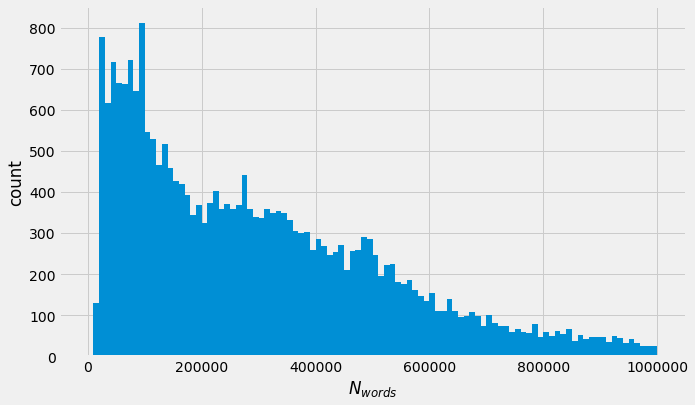

In [34]:
plt.hist(text_lengths, bins = 100, range=[0,1e6]);
plt.xlabel('$N_{words}$'); plt.ylabel('count');

## Broadcast variables: a good way to distribute metadata

Note that our dataset at the moment is composed of `(dictionary, text)` tuples. This is not ideal for several reasons: first, complex structures like dictionaries are more expensive to serialize, so replacing them by simple integer IDs can improve performance. And second, dictionaries are not hashable so cannot serve as keys. 

The solution is to replace the dictionary with just a single ID integer (in this case we already have it, the `gid` or the gutenberg ID of the book). However, as we manipulate the dataset, we will still want ready access to the metadata, but at the moment we have no efficient way of working with it. What we want is to generate a lookup table of metadata that can easily be retrieved when needed. 

For these kinds of situations when passing around some data to all the workers is required, you should use Spark's [broadcast variable](http://spark.apache.org/docs/latest/programming-guide.html#broadcast-variables) mechanism. By placing data inside a broadcast variable, you make it available to all the workers and it only needs to be sent across the network once. The next time a value from the broadcast variable is needed, it's simply taken from the local executor's memory, incurring no extra network cost. 

In [40]:
%%time

meta_dict = dict()

for meta in text_rdd.keys().toLocalIterator() :
    meta_dict[meta['gid']] = meta

CPU times: user 1.46 s, sys: 308 ms, total: 1.76 s
Wall time: 52.5 s


This is now a look-up table that allows us to quickly access all the metadata indexed by `gid`. For example to get the metadata of book with `gid=101`:

In [37]:
meta_dict['101']

{'author_id': '66',
 'author_name': ['Sterling', ' Bruce'],
 'birth_year': '1954',
 'death_year': None,
 'downloads': '196',
 'file_types': {'101-h.htm': 'text/html; charset=iso-8859-1',
  '101.epub.images': 'application/epub+zip',
  '101.epub.noimages': 'application/epub+zip',
  '101.kindle.images': 'application/x-mobipocket-ebook',
  '101.kindle.noimages': 'application/x-mobipocket-ebook',
  '101.rdf': 'application/rdf+xml',
  '101.txt': 'text/plain; charset=us-ascii',
  '101.txt.utf-8': 'text/plain',
  '101.zip': 'text/plain; charset=us-ascii'},
 'filename': '/cluster/home/roskarr/projects/gutenberg_data/gutenberg_text/1/0/101/101.txt',
 'first_name': 'Bruce',
 'gid': '101',
 'language': 'en',
 'last_name': 'Sterling',
 'license': 'Copyrighted. Read the copyright notice inside this book for details.',
 'subtitle': '',
 'title': 'The Hacker Crackdown: Law and Disorder on the Electronic Frontier'}

To get, for example, the author birth year for book with `gid = 101`:

In [38]:
meta_dict['101']['birth_year']

'1954'

Now we want to send this lookup-table to all the executors, so turn it into a broadcast variable: 

In [41]:
sc.setLogLevel('INFO')
# call it meta_b for 'broadcast'
meta_b = sc.broadcast(meta_dict)

`meta_b` is a "broadcast variable" - this means that Spark has taken the object we gave it (`meta_dict`), shipped it to all the workers, and provided us with a new object that we can use to access that data which we named `meta_b`. 

The underlying data stored in `meta_b` can be accessed simply by

    > meta_b.value
    
We'll make use of this soon. If you check the console/terminal output, you will see an INFO message that the broadcast has been created, i.e. 

```
15/06/24 17:18:44 INFO storage.MemoryStore: Block broadcast_6_piece0 stored as bytes in memory (estimated size 910.7 KB, free 4.1 GB)
15/06/24 17:18:44 INFO storage.BlockManagerInfo: Added broadcast_6_piece0 in memory on 10.201.20.22:47821 (size: 910.7 KB, free: 4.1 GB)
15/06/24 17:18:44 INFO spark.SparkContext: Created broadcast 6 from broadcast at PythonRDD.scala:403
```

### Save the metadata dictionary for later use
We will need the metadata dictionary at a later point, so we save it to disk now to avoid having to regenerate it later. 

In [49]:
import pickle

In [52]:
with open('{home}/gutenberg_metadata.dump'.format(home=os.environ['HOME']), 'wb') as f:
    pickle.dump(meta_dict, f)

This saved it to your home directory into a file called `gutenberg_metadata.dump`. 

## Cleaning the data with filtering

Now we're ready to do some quality checks on the data. Let's check out the first couple of metadata entries: 

In [53]:
text_rdd.keys().take(5)

[{'author_id': '116',
  'author_name': ['Various'],
  'birth_year': None,
  'death_year': None,
  'downloads': '13',
  'file_types': {'13637-8.txt': 'text/plain; charset=iso-8859-1',
   '13637-h.htm': 'text/html; charset=iso-8859-1',
   '13637-h.zip': 'text/html; charset=iso-8859-1',
   '13637.epub.images': 'application/epub+zip',
   '13637.epub.noimages': 'application/epub+zip',
   '13637.kindle.images': 'application/x-mobipocket-ebook',
   '13637.kindle.noimages': 'application/x-mobipocket-ebook',
   '13637.rdf': 'application/rdf+xml',
   '13637.txt': 'text/plain; charset=us-ascii',
   '13637.txt.utf-8': 'text/plain'},
  'filename': '/cluster/home/roskarr/projects/gutenberg_data/gutenberg_text/1/3/6/3/13637/13637-8.txt',
  'first_name': None,
  'gid': '13637',
  'language': 'en',
  'last_name': 'Various',
  'license': 'Public domain in the USA.',
  'subtitle': '',
  'title': "McClure's Magazine, Vol. 6, No. 2, January, 1896"},
 {'author_id': '116',
  'author_name': ['Various'],
  'bi

If you look at just the first few entries it becomes clear that we're going to have to do some quality control here. For example, we probably don't want books with "None" as either of the author names, and likewise we have to have the birth date in order to be able to create a time series out of the data in the end. 

Construct an RDD, as above, except that you filter out all the elements that have `None` for `title`, `first_name`, `last_name`, or `birth_year`. In addition, filter out the data with "BC" in either birth or death year. 

As a reminder, here is a cartoon illustration of the difference between `map` and `filter` RDD methods. `map` simply applies the function to each element, returning another element. 

![map](../figs/map_example.svg)

In this example, with `filter` we are filtering out all the even elements of the RDD. The function that is passed to `filter` just has to evaluate to either `True` (1) or `False` (0) given the input data. The function `lambda (k,v): v%2` evaluates to 0 if `v` is even and 1 of `v` is odd. Hence, only the odd values pass the filter. 

![filter](../figs/filter_example.svg)

The `filter_func` has already been defined for you below, but you need to apply it to `text_rdd`. 

In [ ]:
def filter_func(meta) : 
    no_none = all([meta[name] is not None for name in ['title', 'first_name', 'last_name', 'birth_year']])
    if not no_none : 
        return False
    else : 
        no_birth_bc = 'BC' not in meta['birth_year']
        no_death_bc = True if meta['death_year'] is None else 'BC' not in meta['death_year']
        return no_birth_bc & no_death_bc

In [ ]:
# TODO: filter the meta data of the RDD using the filter_func 
# remember that the data of text_rdd is a (metadata, text) tuple -- filter_func only needs the metadata
filtered_rdd = text_rdd.filter(lambda (meta, text): filter_func(meta))

In [ ]:
filtered_rdd.keys().take(5)

How many do we have left? 

In [ ]:
nfiltered = filtered_rdd.count()
print('number of books after filtering: ', nfiltered)
assert(nfiltered == 34123)

#### A final bit of cleanup: 

some of the books end up split across multiple entries. Since it's the same book, each of the entries should have the same `gid`. 

To check for this we will use one of the most basic and common MapReduce patterns -- the key count: 

* map the data into `key`,`value` pairs where `key` is the quantity we want to count and `value` is just 1. In this case, the `key` will be `gid`
* invoke a reduction *by key*, where the reduction operator is a simple addition

Finally, we will sort the result in descending order and print out the first few elements to check whether we have to worry about documents spanning multiple files or not. 

The RDD operations that are needed are [`reduceByKey`](http://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.reduceByKey) and [sortBy](http://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.sortBy).

`reduceByKey` works by grouping all data of a key together and applying the reduction function just to that data. Here's a simple illustration, in this case using a simple addition of two elements as a reduction:

![reducebykey](../../slides/figs/reduceByKey_example.svg)



For the `keyFunc` of the call to `sortBy`, use a `lambda` function that extracts the counts obtained from the `reduceByKey`. 

So, the procedure should be : 

1. `map` the `filtered_rdd` using a lambda function to contain (`gid`, 1) tuples
2. `reduceByKey`
3. `sortBy` (specify decreasing order, see the API) 

In [ ]:
from operator import add

In [ ]:
# map the filtered_rdd to contain just the tuple (gid, 1)
map_filtered = filtered_rdd.map(lambda (meta, text): (meta['gid'],1))

# reduce the map_filtered rdd by key using the add operator to get the total counts per gid
reduced_gid_rdd = map_filtered.reduceByKey(<FILL IN>)

# sort by count and print out the top 5
reduced_gid_rdd.sortBy(<FILL IN>).take(5)

In [ ]:
assert(_ == [(30310, 51), (6478, 43), (3772, 40), (8700, 35), (3332, 33)])

Note that there are several transformations here that lead to the final result, `sorted_reduced`. A common syntax is to group them all together, by enclosing them in `( )` and chaining them: 

In [ ]:
# TODO: repeat the above steps but chain them together
(filtered_rdd.<FILL IN>
                         )

Looks like we have a few that are made up of multiple sections. To combine them, we will use `reduceByKey` which will result in having an RDD of `gid`'s as keys and the combined text of each `gid`. The reduction function in `reduceByKey` can be a simple in-line lambda function that just adds two elements together -- in this case we'll use the `add` function.

In [ ]:
# first, map filtered_rdd to contain tuples (gid, text)
# second, use reduceByKey to combine together text belonging to the same gid
cleaned_rdd = (filtered_rdd.map(lambda (meta, text): (meta['gid'], text))
                           .reduceByKey(add))

As a simple sanity check, lets look at `gid`=6478, which according to the cell above has 43 sections in the original dataset: 

In [ ]:
len(filtered_rdd.map(lambda (meta, text): (meta['gid'],1))
                .lookup(6478))

In [ ]:
len(cleaned_rdd.lookup(6478))

To avoid having to do all these pre-processing steps again at a later point, lets also save the `cleaned_rdd`. 

**In the cells below, replace "YOUR USERNAME" with your own username.**

In [ ]:
cleaned_rdd.saveAsPickleFile('/user/YOUR USERNAME/gutenberg/cleaned_rdd')

This is now saved in the directory we specified, one file per partition:

In [ ]:
!hadoop fs -ls /user/YOUR USERNAME/gutenberg/cleaned_rdd | head

In [ ]:
!hadoop fs -du -h /user/YOUR USERNAME/gutenberg/

Note that here we used the `hadoop` command in the local bash shell (the `!` at the beginning of the line means we are executing the command in the shell). This allows us to access the hadoop filesystem (HDFS), which is separate from the local file system we are used to. You'll notice, for example, that this directory doesn't exist in the *local* filesystem:

In [ ]:
!ls /user/YOUR USERNAME/gutenberg/

You can also browse the filesystem via the [HDFS web UI](http://hadoop.ethz.ch:50070). The `hadoop fs` command has many of the same options as regular Linux/Unix shell commands you might be used to for manipulating files and directories. Try running

```bash
cluster $> module load hadoop
cluster $> hadoop fs -help
```

in a new shell to see all the options. 

### Recap of steps up until this point

We've done quite a lot already with our dataset in Spark, although it's only the beginning!

1. created an RDD of filenames (`filename_rdd`)
2. transformed the `filename_rdd` into an RDD of `(metadata, text)` (`text_rdd`); we also saved this to HDFS
3. filtered out data with bad metadata, e.g. missing author names etc.
3. cleaned up the entries a bit more by merging ones with identical IDs; we called this `cleaned_rdd`

## Shutting down the `SparkContext`

Now that the pre-processing is done, we will shut down the `SparkContext` before continuing to the data analysis notebook. We have all of our results saved in HDFS, so to continue from where we left off will just require loading data from there. 

In [ ]:
sc.stop()

Now that the pre-processing steps are complete, we can continue to the [analysis notebook](part2-ngram-viewer-EMPTY.ipynb)